In [20]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [21]:
dfstocks = pd.read_csv('F:/ASDRP_B/data/SPX/S&PFinanceData2020_2.csv',parse_dates = True)
dftweets = pd.read_csv('F:/ASDRP_B/data/SPX/stocktwits_SPXClassified3_2.csv', parse_dates = True)
dftweets.head()

,Unnamed: 0,Unnamed: 0.1,symbol,message,datetime,user,message_id,sentiment,Content
0,14,15,SPX,spy replace all american engineers with curryb...,2020-12-24T21:31:17Z,1705039,267209000,1.0,spy replace all american engineer with currybo...
1,28,29,SPX,this could test 2800 the spring but buying opp...,2020-12-24T19:14:17Z,1902914,267188014,1.0,this could test 2800 the spring but buying opp...
2,32,33,SPX,indexes close with some gains after the trade ...,2020-12-24T18:53:50Z,2084625,267183905,1.0,index close with some gain after the trade dea...
3,33,34,SPX,lotto added spx 3720,2020-12-24T18:29:22Z,1092817,267178398,1.0,lotto added spx 3720
4,35,36,SPX,merry christmas 900 followers and the future t...,2020-12-24T18:27:21Z,2175262,267177890,1.0,merry christmas 900 follower and the future th...


In [22]:
def sentimentIndex(x):
    return np.log( (1 + x[1]) / (1 + x[0]))

In [23]:
dftweets = dftweets.dropna()
dftweets['sentiment'] = dftweets['sentiment'].astype('int')
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'])
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'].dt.date)
dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets = dftweets.pivot_table(index='datetime',columns='sentiment', aggfunc='size')
print(dftweets[1])
dftweets['sentimentIndex'] = dftweets.apply(sentimentIndex, axis = 1)

dftweets.sort_values('datetime', inplace=True, ascending=True)
#rowsdiff2 = dftweets['sentimentIndex']
#dfstocks.set_index('Date').diff()
#rowsdiff2.diff()
#dftweets['Differencetweets'] = rowsdiff2
#dftweets['Differencetweets'].iloc[0] = 0


merged = pd.merge(left=dftweets, left_on='datetime',
         right=dfstocks, right_on='Date')
direction = []
for i in merged['Difference']:
    if i > 0:
        direction.append(1)
    else:
        direction.append(0)
merged['Direction'] = direction
merged = merged[1:]

merged.head()

datetime
2020-01-01     18
2020-01-02     53
2020-01-03     97
2020-01-04     32
2020-01-05     23
             ... 
2020-12-21    141
2020-12-22     69
2020-12-23    105
2020-12-24     49
2020-12-25      3
Name: 1, Length: 360, dtype: int64


,0,1,sentimentIndex,Date,Open,High,Low,Close,Adj Close,Volume,Difference,Direction
1,154,97,-0.458458,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3461290000,-23.000000,0
2,89,69,-0.251314,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,11.429932,1
3,69,66,-0.043803,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,-9.100098,0
4,134,123,-0.084993,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,15.870117,1
5,92,69,-0.284104,2020-01-09,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,21.649902,1


In [24]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close', 'sentimentIndex','Direction']]
target = merged_sim.iloc[:,-1:].values
train_data = merged_sim.loc[:,merged_sim.columns != 'Direction'].values
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size = 0.3, random_state = 0)

In [25]:
clf = lgb.LGBMClassifier(num_leaves = 256, n_estimators = 1024, max_depth = 10)
clf.fit(X_train, y_train)

LGBMClassifier(max_depth=10, n_estimators=1024, num_leaves=256)

In [26]:
# predict the results
y_pred=clf.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6933


In [28]:
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 1.0000


<AxesSubplot:>

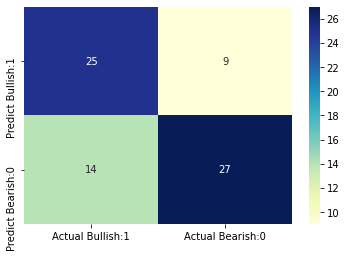

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# print('Confusion matrix\n\n', cm)
# print('\nTrue Positives(TP) = ', cm[0,0])
# print('\nTrue Negatives(TN) = ', cm[1,1])
# print('\nFalse Positives(FP) = ', cm[0,1])
# print('\nFalse Negatives(FN) = ', cm[1,0])
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Bullish:1', 'Actual Bearish:0'], 
                                 index=['Predict Bullish:1', 'Predict Bearish:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68        34
           1       0.75      0.66      0.70        41

    accuracy                           0.69        75
   macro avg       0.70      0.70      0.69        75
weighted avg       0.70      0.69      0.69        75



Text(0.5, 1.0, 'Importance of Classifier Features')

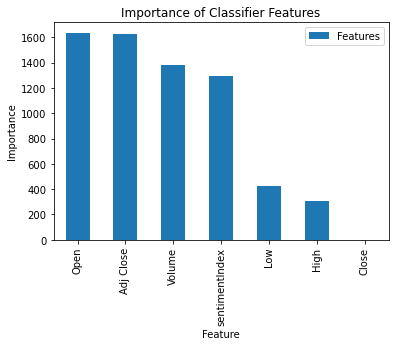

In [31]:
#lgb.plot_importance(clf)
merged_sim2  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close', 'sentimentIndex']]
importances = list(zip(clf.feature_importances_, merged_sim2.columns))
importances.sort(reverse=True)
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar')
plt.legend(['Features'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Importance of Classifier Features')

In [40]:
#import graphviz
import os

#os.environ["PATH"] += os.pathsep + "F:\\anaconda3\\Library\\bin\\graphviz"
#os.environ['PATH'] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.environ['PATH']=os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

lgb.create_tree_digraph(clf, show_info = ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close', 'sentimentIndex'], orientation = "vertical")
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
# with open('fst.svg', 'w') as f:
#     f.write(image._repr_svg_())

<Figure size 10800x7200 with 0 Axes>

In [33]:
print(os.environ["PATH"])

F:\anaconda3;F:\anaconda3\Library\mingw-w64\bin;F:\anaconda3\Library\usr\bin;F:\anaconda3\Library\bin;F:\anaconda3\Scripts;F:\anaconda3\bin;F:\anaconda3\condabin;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;F:\bin;F:\python\Scripts;F:\python;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;F:\BRACKETS\command;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;F:\MinGW\bin;F:\PuTTY;F:\nodejs;C:\ProgramData\chocolatey\bin;F:\MATLAB\R2020b\bin;C:\Program Files\Git LFS;F:\Git LFS;C:\Program Files\Git\cmd;F:\anaconda3;F:\anaconda3\bin;F:\anaconda3\Scripts;C:\Program Files (x86)\Graphviz2.38\bin;C:\Users\emu4y\AppData\Local\Programs\Python\Launcher;F:\PyCharm\bin;C:\Users\emu4y\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x6

In [34]:
#C:\Program Files (x86)\Graphviz2.38\bin